In [1]:
import emcee
import matplotlib
import numpy as np
import corner
import scipy.optimize as op

%matplotlib inline  

# some important variables
g = 6.6743e-8
msun = 1.989e33
au = 1.496e13
pi = 3.14159

In [2]:
nbin = 59 ## number of binaries in sample
nvar = 5

## read in delK, parallax
delk = np.zeros(nbin)
edelk = np.zeros(nbin)
plxval = np.zeros(nbin)
plxprior = np.zeros(nbin)
name = strs = ['']*nbin
k = np.zeros(nbin)
ek = np.zeros(nbin)
f = open('data2.txt','r')
header1 = f.readline()
i=0
for line in f:
    line = line.strip()
    columns = line.split()
    name[i] = columns[0]
    delk[i] = float(columns[1])
    edelk[i] = float(columns[2])
    plxval[i] = float(columns[3])
    plxprior[i] = float(columns[4])
    k[i] = float(columns[5])
    ek[i] = float(columns[6])
    i+=1
f.close()

## now for the sma**3/per**2
f = open('fits.txt','r')
header1 = f.readline()
i=0
smaper = np.zeros(nbin)
esmaper = np.zeros(nbin)
for line in f:
    line = line.strip()
    columns = line.split()
    smaper[i] = float(columns[0])
    esmaper[i] = float(columns[1])
    i+=1
f.close()

fluxratio = 10.0**(delk/2.5)
del_eps = 2.5*np.log10(1.0+1.0/fluxratio)
kp = del_eps+k
ks = kp + delk

# compute MC errors on Kp, Ks
mcsize = 50000
ekp = kp*0.
eks = ks*0.
for i in range(0,len(ks)):
    ktmp = k[i]+ek[i]*np.random.standard_normal(mcsize)
    deltmp = delk[i]+edelk[i]*np.random.standard_normal(mcsize)
    fluxratio = 10.0**(deltmp/2.5)
    del_eps = 2.5*np.log10(1.0+1.0/fluxratio)
    kpt = del_eps+ktmp
    kst = kp[i] + ktmp
    ekp[i] = np.std(kpt)
    eks[i] = np.std(kst)



result_ben = np.array([0.2311,-0.1352, 0.0400, 0.0038, -0.0032]) # benedict fit value
result1 = np.array([0.23323026,-0.10887911, 0.019990399, 0.00027286744, -0.00046073982])# Mann fit value
result2 = plxval
result_delf = [0.001*1.8,0.001*6.12,0.001*13.205,-6.2315*0.001,0.001*0.37529]
result3= [-0.63295206,-0.20778677,-0.013368276,0.0048833552,0.0014093654] ## one I measured in IDL
result = np.concatenate([result3,result2])

In [3]:
factor = (au**3.)*((4.0*np.pi**2.)/(g*msun))
empmass = factor*smaper/plxval**3
e_empmass = empmass*np.sqrt((esmaper/smaper)**2 +9.0*(plxprior/plxval)**2)

In [4]:
## this is mostly for checking things are reasonable
mka = kp - 5.0*(np.log10(1000.0/plxval)-1.)
mkb = ks - 5.0*(np.log10(1000.0/plxval)-1.)
a, b, c, d, e = result3
mka_err = 0.02## for now
mkb_err = 0.02## for now
mass1 = 10.0**(a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3 + e*(mka-7.5)**4)
mass2 = 10.0**(a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3 + e*(mkb-7.5)**4)
mass1_err = (np.log(10)*(b+2*c*(mka-7.5)+3*d*(mka-7.5)**2+4*e*(mka-7.5)**3))*mass1*mka_err
mass2_err = (np.log(10)*(b+2*c*(mkb-7.5)+3*d*(mkb-7.5)**2+4*e*(mkb-7.5)**3))*mass2*mkb_err
#mass1 = 10.0**(a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3)
#mass2 = 10.0**(a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3)
#mass1_err = (np.log(10)*(b+2*c*(mka-7.5)+3*d*(mka-7.5)**2))*mass1*mka_err
#mass2_err = (np.log(10)*(b+2*c*(mkb-7.5)+3*d*(mkb-7.5)**2))*mass2*mkb_err

model_err = np.sqrt(mass1_err**2+mass2_err**2)
model = mass1+mass2

for i in range(0,len(empmass)):
    print "{:10s}".format(name[i]), \
    "{0:.3f}".format(empmass[i]),"{0:.3f}".format(e_empmass[i]), \
    "{0:.4f}".format(model[i]),"{0:.4f}".format(model_err[i]),"{0:.3f}".format(100*model_err[i]/model[i]), \
    "{0:.4f}".format(mka[i]),"{0:.4f}".format(mkb[i]), \
    "{0:.3f}".format(ekp[i]),"{0:.3f}".format(eks[i]), \
    "{0:.3f}".format(mass1[i]),"{0:.3f}".format(mass2[i]), \
    "{0:.1f}".format(np.abs(empmass[i]-model[i])/np.sqrt(e_empmass[i]**2+model_err[i]**2))   
    
print np.sum((empmass-model)**2/(e_empmass**2+model_err**2))/(empmass.size-5.)

GJ623      0.494 0.004 0.4704 0.0030 0.642 6.4968 9.0678 0.023 0.023 0.362 0.109 4.4
GJ4024     0.917 0.139 0.8811 0.0044 0.501 5.5041 6.4691 0.019 0.018 0.515 0.366 0.3
PMJ02133+3648 0.245 0.035 0.2586 0.0018 0.700 8.1313 9.6003 0.018 0.018 0.171 0.088 0.4
HIP11542   1.457 0.183 1.3196 0.0061 0.463 4.6013 4.8643 0.019 0.018 0.688 0.632 0.7
HD239960   0.460 0.011 0.4464 0.0030 0.677 7.1190 8.1570 0.030 0.029 0.278 0.168 1.3
HD15285    1.389 0.079 1.3345 0.0062 0.462 4.6580 4.7310 0.020 0.018 0.675 0.659 0.7
Gl844      0.871 0.095 0.9062 0.0044 0.489 5.8306 5.9476 0.022 0.021 0.462 0.444 0.4
HIP9724    0.514 0.027 0.5504 0.0032 0.588 5.9100 9.2460 0.020 0.020 0.450 0.101 1.3
Gl831      0.418 0.003 0.4212 0.0029 0.685 7.1793 8.3793 0.020 0.020 0.270 0.151 0.6
Gl804      0.996 0.135 0.9348 0.0046 0.490 5.2621 6.3851 0.017 0.016 0.557 0.378 0.5
Gl792      0.356 0.028 0.3104 0.0022 0.707 8.0542 8.6312 0.017 0.016 0.177 0.133 1.6
Gl747      0.429 0.026 0.4424 0.0030 0.685 7.5507 7.6637 0.021

In [5]:
def lnlike(theta, smaper, esmaper, kp, ks, ekp, eks):
    zp = 7.5e0
    au = 1.496e13
    msun = 1.989e33
    g = 6.6743e-8 
    a, b, c, d, e = theta[0:5]
    mplx = theta[5:theta.size]
    if np.min(mplx) <= 0:
        return -np.inf
    factor = (au**3.)*((4.0*np.pi**2.)/(g*msun))
    empmass = factor*smaper/mplx**3
    #e_empmass = empmass*np.sqrt((esmaper/smaper)**2 +9.*(plxprior/plxval)**2)
    e_empmass = empmass*(esmaper/smaper)**2
    mka = kp - 5.0*(np.log10(1000.0/mplx)-1.)
    mkb = ks - 5.0*(np.log10(1000.0/mplx)-1.)
    mka-=zp
    mkb-=zp
    mass1 = 10.0**(a + b*mka + c*mka**2. + d*mka**3. + e*mka**4.)
    mass2 = 10.0**(a + b*mkb + c*mkb**2. + d*mkb**3. + e*mkb**4.)
    #mass1 = 10.0**(a + b*mka + c*mka**2. + d*mka**3.)
    #mass2 = 10.0**(a + b*mkb + c*mkb**2. + d*mkb**3.)
    if np.min(mass1) <= 0 or np.min(mass2) <= 0:
        return -np.inf
    mka_err = ekp
    mkb_err = eks
    mass1_err = np.abs((np.log(10.)*(b+2.*c*mka+3.*d*mka**2+4.*e*mka**3.))*mass1*mka_err)
    mass2_err = np.abs((np.log(10.)*(b+2.*c*mkb+3.*d*mkb**2+4.*e*mkb**3.))*mass2*mkb_err)
    #mass1_err = np.abs((np.log(10.)*(b+2.*c*mka+3.*d*mka**2))*mass1*mka_err)
    #mass2_err = np.abs((np.log(10.)*(b+2.*c*mkb+3.*d*mkb**2))*mass2*mkb_err)
    model_err = np.sqrt(mass1_err**2+mass2_err**2)
    model = mass1+mass2
    inv_sigma2 = 1.0/np.sqrt(e_empmass**2+model_err**2)
    return -0.5*(np.sum((empmass-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [6]:
def lnprior(theta, plxval, plxprior):
    mplx = theta[5:theta.size]
    lp = 0
    if np.min(mplx) <= 0:
        return -np.inf
    for i in range(0,len(mplx)):
        lp += ((np.float(mplx[i])-np.float(plxval[i]))**2)/(np.float(plxprior[i])**2)
    lp*=(-0.5)
    if not np.isfinite(lp):
        return 0.0
    return lp

In [7]:
def lnprob(theta, plxval, plxprior, smaper, esmaper, kp, ks, ekp, eks):
    lp = lnprior(theta, plxval, plxprior)
    if not np.isfinite(lp):
        return -np.inf
    like = lnlike(theta, smaper, esmaper, kp, ks, ekp, eks)
    if not np.isfinite(like):
        return -np.inf
    val = lp + like
    return val

In [8]:
ndim, nwalkers = result.size, 800
pos = [result + 1e-2*result*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(plxval, plxprior, smaper, esmaper, kp, ks, ekp, eks),
                               threads=6)
## burn-in and/or testing
smallstep = 5000
pos, prob, state = sampler.run_mcmc(pos, smallstep)
sampler.reset()
print 'Finished burn/test phase'


Finished burn/test phase


In [9]:
import time
start_time = time.time()
nsteps = 500000
thin = 100
kwargs = {'thin': thin }
print 'Starting run!'
for i, result in enumerate(sampler.sample(pos, iterations=nsteps, **kwargs)):
    if (i+1) % 10000 == 0:
        print("{0:5.1%}".format(float(i) / nsteps)),
        ("{0:5.2%}".format((time.time() - start_time)/60))
print 'Done, runtime:'
print (time.time() - start_time)/60
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Starting run!
 2.0%  4.0%  6.0%  8.0% 10.0% 12.0% 14.0% 16.0% 18.0% 20.0% 22.0% 24.0% 26.0% 28.0% 30.0% 32.0% 34.0% 36.0% 38.0% 40.0% 42.0% 44.0% 46.0% 48.0% 50.0% 52.0% 54.0% 56.0% 58.0% 60.0% 62.0% 64.0% 66.0% 68.0% 70.0% 72.0% 74.0% 76.0% 78.0% 80.0% 82.0% 84.0% 86.0% 88.0% 90.0% 92.0% 94.0% 96.0% 98.0% 100.0% Done, runtime:
1315.75738678
Mean acceptance fraction: 0.161


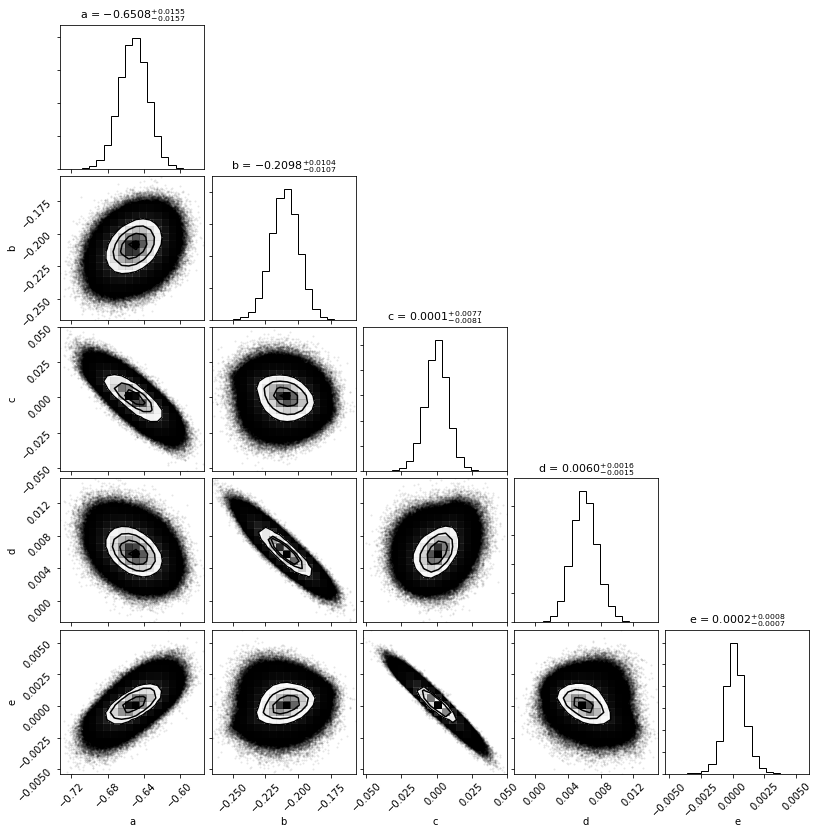

In [10]:
#print dat.shape,nwalkers,nsteps,thin
import corner
from matplotlib.backends.backend_pdf import PdfPages
dat = sampler.flatchain#chain
like = sampler.flatlnprobability
arr = dat

fig = corner.corner(arr[:,0:nvar], labels=['a',r'b','c',r'd',r'e'], show_titles=True, title_kwargs={"fontsize": 11},title_fmt='.4f')
pp = PdfPages('output_params_log.pdf')
pp.savefig(fig)
pp.close()

In [11]:
dat = sampler.chain
prob = sampler.lnprobability
accept = sampler.acceptance_fraction
arr = dat.reshape((dat.shape)[0]*(dat.shape)[1],dat.shape[2])
print 'name plx_mcmc plx_err_mcmc plxinput plx_prior diff_sig1 diff_sig2'
for i in range(nvar,dat.shape[2]):
    print "{:10s}".format(name[i-nvar]), \
    "{0:.4f}".format(np.median(arr[:,i])),"{0:.4f}".format(np.std(arr[:,i])),"{0:.4f}".format(plxprior[i-nvar]), \
    "{0:.4f}".format(plxval[i-nvar]),"{0:.4f}".format((plxval[i-nvar]-np.median(arr[:,i]))/plxprior[i-nvar]), \
    "{0:.4f}".format((plxval[i-nvar]-np.median(arr[:,i]))/np.sqrt(plxprior[i-nvar]**2+np.std(arr[:,i])**2))
    

name plx_mcmc plx_err_mcmc plxinput plx_prior diff_sig1 diff_sig2
GJ623      125.0052 0.3000 0.3000 125.0000 -0.0172 -0.0121
GJ4024     50.6861 1.4675 2.5000 50.1000 -0.2344 -0.2022
PMJ02133+3648 74.2700 2.9743 3.5000 74.6000 0.0943 0.0718
HIP11542   39.7753 0.8044 1.6000 38.2000 -0.9846 -0.8797
HD239960   249.9990 1.8926 1.9000 249.9000 -0.0521 -0.0369
HD15285    59.1846 0.9344 1.1000 58.3000 -0.8042 -0.6129
Gl844      61.1495 1.6626 2.2000 61.8000 0.2957 0.2359
HIP9724    109.1958 1.8021 1.8700 109.5900 0.2108 0.1518
Gl831      125.3021 0.2998 0.3000 125.3000 -0.0069 -0.0049
Gl804      48.2577 1.2102 2.1000 47.4000 -0.4084 -0.3539
Gl792      69.3746 1.1522 1.2000 69.0000 -0.3122 -0.2252
Gl747      122.3977 2.3903 2.5000 122.3000 -0.0391 -0.0282
Gl695C     120.3328 0.1599 0.1600 120.3300 -0.0173 -0.0122
Gl660      86.1808 2.1557 2.4700 85.2300 -0.3850 -0.2900
Gl54       126.9052 0.3993 0.4000 126.9000 -0.0130 -0.0092
Gl494      85.5624 1.3320 1.5000 85.5000 -0.0416 -0.0311
Gl473      

In [19]:
factor = (au**3.)*((4.0*np.pi**2.)/(g*msun))
mass = factor*smaper/plxval**3
#e_empmass = empmass*np.sqrt((esmaper/smaper)**2 +9.0*(plxprior/plxval)**2)
#sma_au = sma*au*(1000/plxval)
#mass = (4.*(pi**2.))*((sma_au**3./per**2.)/g)/msun

mka = kp - 5.0*(np.log10(1000.0/plxval)-1.)
mkb = ks - 5.0*(np.log10(1000.0/plxval)-1.)

best = (like == max(like))
a = arr[best,0]#np.median(arr[:,0])
b = arr[best,1]#np.median(arr[:,1])
c = arr[best,2]#np.median(arr[:,2])
d = arr[best,3]#np.median(arr[:,3])
e = arr[best,4]#np.median(arr[:,4])
print a,b,c,d,e
#mass1 = a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3 + e*(mka-7.5)**4
#mass2 = a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3 + e*(mkb-7.5)**4
mass1 = 10.0**(a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3 + e*(mka-7.5)**4)
mass2 = 10.0**(a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3 + e*(mkb-7.5)**4)
#mass1 = 10.0**(a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3)
#mass2 = 10.0**(a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3)
sysmass = mass1+mass2
a, b, c, d, e = result1
mass1 = a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3 + e*(mka-7.5)**4
mass2 = a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3 + e*(mkb-7.5)**4
sysmass_mann = mass1+mass2
a, b, c, d, e = result_ben
mass1 = a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3 + e*(mka-7.5)**4
mass2 = a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3 + e*(mkb-7.5)**4
sysmass_ben = mass1+mass2

[-0.64946618] [-0.21540353] [ 0.00097601] [ 0.00666571] [ -7.84727589e-05]


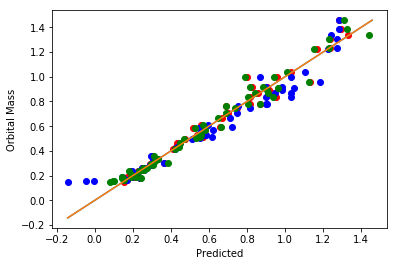

In [20]:
import matplotlib.pyplot as plt

rng = [np.min(np.concatenate([sysmass,sysmass_ben,mass])),
         np.max(np.concatenate([sysmass,sysmass_ben,mass]))]
plt.figure()
plt.plot(sysmass,mass,'ro')
plt.ylabel('Orbital Mass')
plt.xlabel('Predicted')
plt.plot(sysmass_ben,mass,'ro',color='b')
plt.plot(rng,rng)
plt.plot(sysmass_mann,mass,'ro',color='g')
plt.plot(rng,rng)
## blue = benedict
## green = mann idl
## red = python

74.2700393608 74.6
(4000000,) (4000000,)


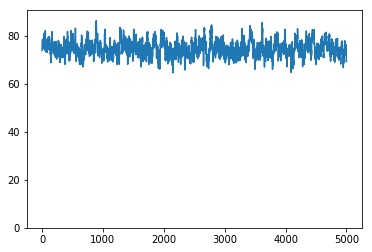

In [21]:
newprob = prob.reshape((prob.shape)[0]*(dat.shape)[1])
num = 7
plt.plot(dat[2,:,num])
print np.median(arr[:,num]),plxval[num-5]

#
print newprob.shape,arr[:,0].shape
n, bins, patches = plt.hist(newprob[np.isfinite(newprob)], 50, normed=1, facecolor='green', alpha=0.75)
plt.show()

[-0.64946618] [-0.21540353] [ 0.00097601] [ 0.00666571] [ -7.84727589e-05]


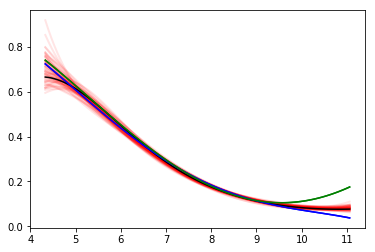

In [25]:
best = (like == max(like))
a = arr[best,0]#np.median(arr[:,0])
b = arr[best,1]#np.median(arr[:,1])
c = arr[best,2]#np.median(arr[:,2])
d = arr[best,3]#np.median(arr[:,3])
e = arr[best,4]#np.median(arr[:,3])

print a,b,c,d,e
rng = [np.min(np.concatenate([mka,mkb])),np.max(np.concatenate([mka,mkb]))]
mk = np.linspace(rng[0],rng[1],100)
mass1 = 10.0**(a + b*(mk-7.5) + c*(mk-7.5)**2 + d*(mk-7.5)**3 + e*(mk-7.5)**4)
a, b, c, d, e = result1
mass2 = a + b*(mk-7.5) + c*(mk-7.5)**2 + d*(mk-7.5)**3 + e*(mk-7.5)**4
mass3 = 0.585825902+3.87151019e-1*mk-1.21729937e-1*mk**2.+1.05529583e-2*mk**3.-2.72615872e-4*mk**4.

## red = new fit
## blue = Benedict
## green = How to constrain your M dwarf
#plt.plot(mk,mass1,color='o')
plt.plot(mk,mass2,color='b')
plt.plot(mk,mass3,color='g')


for i in range(0,60):
    index = np.random.randint(len(arr[:,0]))
    if np.isfinite(newprob[index]):
        a, b, c, d, e= arr[index,0:nvar]
        mass = 10.0**(a + b*(mk-7.5) + c*(mk-7.5)**2 + d*(mk-7.5)**3 + e*(mk-7.5)**4)
        plt.plot(mk,mass,color='r',lw=2,alpha=0.1)

plt.plot(mk,mass1,color='black')
plt.plot(mk,mass2,color='b')
plt.plot(mk,mass3,color='g')

plt.show()


In [16]:
## save out the relevant chains
import pyfits
pyfits.writeto('Mk-Mass_log_emcee.fits', sampler.chain, clobber=True)
pyfits.writeto('Mk-Mass_log_emcee_accept.fits', sampler.acceptance_fraction, clobber=True)
pyfits.writeto('Mk-Mass_log_emcee_lnprob.fits', sampler.lnprobability, clobber=True)
pyfits.writeto('Mk-Mass_log_emcee_acor.fits', sampler.acor, clobber=True)

/Users/amann/anaconda2/lib/python2.7/site-packages/pyfits/file.py:372: UserWarning: Overwriting existing file 'Mk-Mass_log_emcee.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/amann/anaconda2/lib/python2.7/site-packages/pyfits/file.py:372: UserWarning: Overwriting existing file 'Mk-Mass_log_emcee_accept.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/amann/anaconda2/lib/python2.7/site-packages/pyfits/file.py:372: UserWarning: Overwriting existing file 'Mk-Mass_log_emcee_lnprob.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


AutocorrError: The chain is too short to reliably estimate the autocorrelation time